# 20 HOURS IN TOTAL

In [1]:
# 7.30 am 7 Jan 2020 until 11 am (4.5 hours)
# 11.30 am 7 Jan 2020 until 12pm (0.5 hour)
# 1pm 7 Jan 2020 until 2.30pm (1.5 hour)
# 11.45 am 8 Jan 2020 until 1.15 pm (1.5 hour)
# 3.30 pm 8 Jan 2020 until 6.30pm (3 hours)
# 9pm 8 Jan 2020 until 10.30 (1.5 hour)
# 9.30 am 9 Jan 2020 until 1pm (3.5 hours)
# 9pm 16 Jan 2020 until 11pm (2 hours)
# 8am 17 Jan 2020 until 10am (2 hours)

In [2]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

pd.options.mode.chained_assignment = None 

In [3]:
loan = pd.read_csv('./data/loan.csv')
payment = pd.read_csv('./data/payment.csv')
clarity_underwriting = pd.read_csv('./data/clarity_underwriting_variables.csv', low_memory=False)

# Data Cleaning, Exploration and Visualisation

Here we are going to look at the three csv files provided. Different plots are plotted to get a sense of the data provided, some might not be quite useful in deciding the models but they did help in understanding the data better.

## loan.csv

A function to check the missing data in a dataframe is written for convenience. 

In [4]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])

We are only interested in funded loans to train a new predictive model, as only the funded loans tell us the history of the applicants. First, we have to confirm that there is no fpStatus when the loan is approved but not funded, i.e. that the loan application is not proceeded. The cell below confirms this.

In [5]:
check_fpStatus = loan.loc[(loan['approved']==True) & (loan['isFunded']!=1)]['fpStatus'].unique()
check_fpStatus

array([nan], dtype=object)

clearfraudscore's are mapped from clarity_underwriting_variables.csv to the funded_loan dataframe, which is a modified version of the dataframe in loan.csv.  

In [6]:
funded_loan = loan.loc[(loan['approved']==True) & (loan['isFunded']==1)]
funded_loan = funded_loan.set_index(['state', 'anon_ssn', 'loanId'])
mapping = dict(clarity_underwriting[['underwritingid', 'clearfraudscore']].values)
funded_loan['clearfraudscore'] = funded_loan.clarityFraudId.map(mapping)
funded_loan.drop(columns=['approved', 'isFunded', 'originated', 'clarityFraudId'], inplace=True)
all_states = funded_loan.index.get_level_values('state').unique()
all_applicants = funded_loan.index.get_level_values('anon_ssn').unique()

In [7]:
missing_data(funded_loan)

,Total,Percentage
clearfraudscore,6894,17.685085
nPaidOff,21,0.053871
fpStatus,9,0.023088
hasCF,0,0.000000
leadCost,0,0.000000
leadType,0,0.000000
originallyScheduledPaymentAmount,0,0.000000
loanAmount,0,0.000000
loanStatus,0,0.000000
originatedDate,0,0.000000


The distribution of the loan status is plotted for two reasons: first, to know what loan statuses there are; second, to see how these statuses, which should be the output of our prediction model, can be modified to make a simpler model. It is observed it is probably hard to classify loans into these loan statuses, seeing that there are certain statuses that can raised randomly. For example, external collection and internal collection are similar, with the only difference being the party that handles the debt. 

Moreover, from a rudimentary business perspective, what the company seeks is to avoid making losses. In other words, as long as the paid amount is larger than the borrowed amount, the company is making profit regardless of the loan status of an applicant.

As such, it is decided that the total paid amount should be mapped from payment.csv, and the net profit, indicated by ratio=(total_paid_amount-leadCost)/borrowed_amount is calculated. The prediction model hence seeks to classify the inputs into two different categories, profit-making and loss-making. A ratio bigger or equal to 1 indicates that the company is at least breaking even with the loan agreement, and a ratio smaller than 1 indicates that the company is losing money.

Note that new loans will be removed as the it is not yet known whether the company will be making profit from them. 

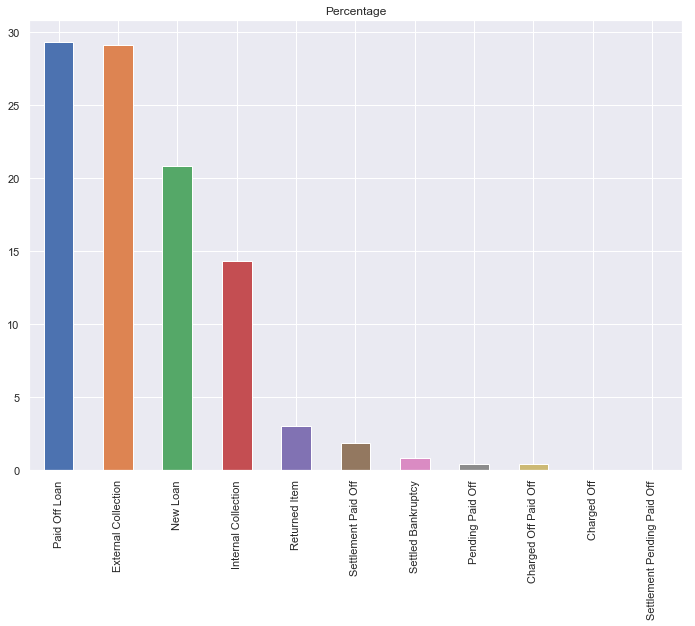

In [8]:
loanStatus_type_frequency = funded_loan['loanStatus'].value_counts(normalize=False).sort_values(ascending=False)

loanStatus_type_frequency = pd.concat([loanStatus_type_frequency, \
                                       100*loanStatus_type_frequency/loanStatus_type_frequency.sum()], axis=1)
loanStatus_type_frequency.columns = range(loanStatus_type_frequency.shape[1])
loanStatus_type_frequency.rename(columns={loanStatus_type_frequency.columns[0]: 'Count', \
                                          loanStatus_type_frequency.columns[1]: 'Percentage'}, inplace=True)
loanStatus_type_frequency['Percentage'].plot.bar(rot=90)
plt.title('Percentage')
plt.show()

External Collection: outsource the debt-collection activity to a third party to recover funds that are past due, or from accounts that are in default

Internal Collection: internal department or a debt-collection subsidiary to handle the debt-collection activity***

Settled Bankruptcy: nothing is collected

Charged Off: occurs when a consumer becomes severely delinquent on a debt. Traditionally, creditors will make this declaration at the point of six months without payment

Settlement Pending Paid Off

Returned Item: only 1 payment missing due to insufficient funds

Settlement Paid Off: an agreement to pay less than the balance due to satisfy the debt has been fulfilled

Charged Off Paid Off: paid off the charge-off

Pending Paid Off

Settlement Pending Paid Off

New Loan: In the process, has been paid up to date




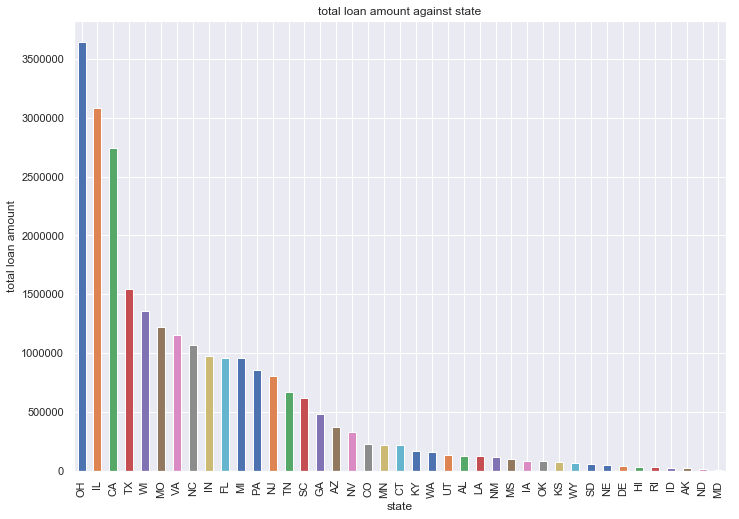

In [9]:
state_loan_ranking = \
funded_loan.groupby(funded_loan.index.get_level_values('state'))['loanAmount'].sum().sort_values(ascending=False)
state_loan_status_distribution = \
funded_loan.groupby(funded_loan.index.get_level_values('state'))['loanStatus'].value_counts(normalize=True)
state_loan_ranking.plot.bar(rot=90)
plt.title('total loan amount against state')
plt.xlabel('state')
plt.ylabel('total loan amount')
plt.show()

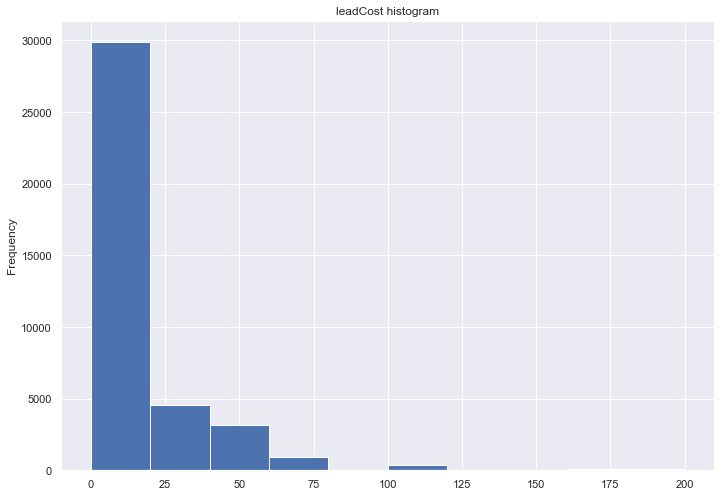

In [10]:
funded_loan['leadCost'].plot.hist()
plt.title('leadCost histogram')
plt.show()

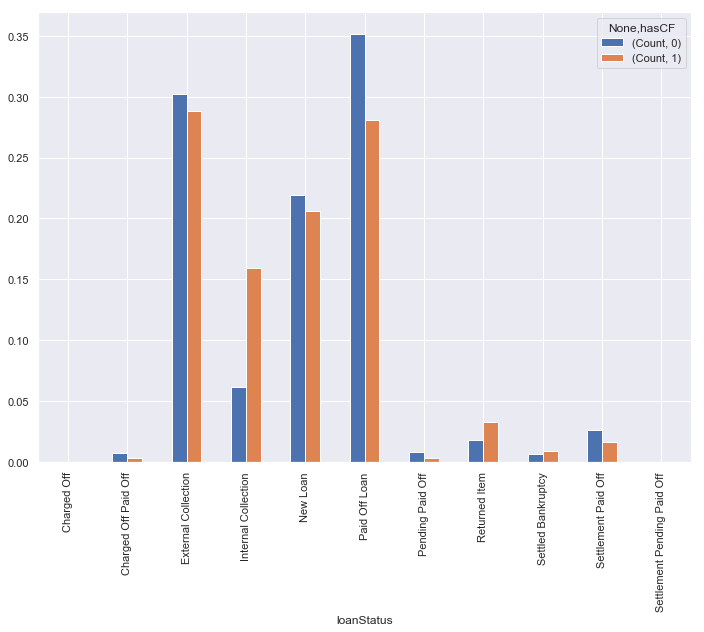

In [11]:
has_CF = pd.Series.to_frame(funded_loan.groupby('hasCF')['loanStatus'].value_counts(normalize=True))
has_CF.rename(columns={'loanStatus': 'Count'}, inplace=True)
has_CF.unstack(level=0).plot.bar()
plt.show()

## payment.csv

In [12]:
missing_data(payment)

,Total,Percentage
paymentReturnCode,657831,95.425784
paymentStatus,0,0.000000
paymentAmount,0,0.000000
fees,0,0.000000
principal,0,0.000000
paymentDate,0,0.000000
isCollection,0,0.000000
installmentIndex,0,0.000000
loanId,0,0.000000


A paymentStatus is marked 'Complete' for loanId=='LL-I-12152161'. Assume that means 'Checked'. The cell below maps the total paid amount under each loanID to the funded_loan dataframe.

In [13]:
paid_amount = pd.Series.to_frame(payment.groupby(['loanId', 'paymentStatus'])['paymentAmount'].sum())
paid_amount.drop(labels=['Rejected', 'Cancelled', 'None', 'Skipped', 'Pending', 'Returned',
                         'Rejected Awaiting Retry'], axis=0, level='paymentStatus', inplace=True)
# paid_amount.loc[paid_amount.index.get_level_values('paymentStatus') == 'Complete']

In [14]:
mapping2 = \
dict(np.stack([paid_amount.index.get_level_values('loanId').values, paid_amount['paymentAmount'].values]).T)

funded_loan['paymentAmount'] = funded_loan.index.get_level_values('loanId').map(mapping2)
funded_loan['nettProfit'] = funded_loan['paymentAmount'] - funded_loan['leadCost']
funded_loan['payloanRatio'] = funded_loan['nettProfit']/funded_loan['loanAmount']

In [15]:
missing_data(funded_loan)

,Total,Percentage
payloanRatio,7140,18.316146
nettProfit,7140,18.316146
paymentAmount,7140,18.316146
clearfraudscore,6894,17.685085
nPaidOff,21,0.053871
fpStatus,9,0.023088
hasCF,0,0.000000
leadCost,0,0.000000
leadType,0,0.000000
originallyScheduledPaymentAmount,0,0.000000


If loanStatus == New Loan, that means the loan has not expired yet. Hence, it should be removed from the credit score valuation.

In [16]:
funded_loan = funded_loan.drop(funded_loan.loc[funded_loan['loanStatus']=='New Loan'].index)

In [17]:
ratioPartition = pd.Series.to_frame(pd.cut(funded_loan['payloanRatio'], [0, 1, float('inf')]))
ratioPartition.rename({'payloanRatio': 'ratioPartition'}, axis=1, inplace=True)
funded_loan = pd.concat([funded_loan, ratioPartition], axis=1)

In [18]:
partition = pd.Series.to_frame(pd.cut(funded_loan['clearfraudscore'], [0, 200, 400, 600, 800, 1000]))
partition.rename({'clearfraudscore': 'clearfraudscorePartition'}, axis=1, inplace=True)
funded_loan = pd.concat([funded_loan, partition], axis=1)

The cell below seeks to explore the relationship between the prediction model output and the clearfraudscore provided. The scatter plot does not reveal much information, and the pearson correlation is computed. Unsurprisingly, a small value of 0.1 is recorded because there is no significant linear relationship between the two variables. 

Hence, the box plot and the bar plot are then drawn to see if there are any interesting observations, i.e. there might be some non-linear relationships between the two variables that could help in the prediction model. The figures, however, do not look very interesting, and very little can be informed from the plots. 

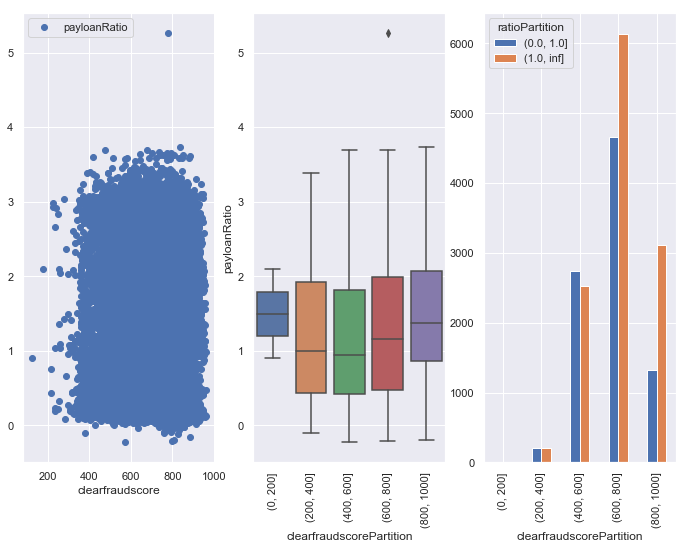

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

funded_loan.plot(x='clearfraudscore', y='payloanRatio', style='o', ax=ax1)
sns.boxplot(x=funded_loan['clearfraudscorePartition'], y=funded_loan['payloanRatio'], ax=ax2)
plt.setp(ax2.get_xticklabels(), rotation=90)

funded_loan.groupby(funded_loan['clearfraudscorePartition'])\
['ratioPartition'].value_counts().unstack().plot.bar(ax=ax3)

plt.show()

In [20]:
funded_loan['clearfraudscore'].corr(funded_loan['payloanRatio'], method='pearson')

0.10735213161290169

In [21]:
partition2 = pd.Series.to_frame(pd.cut(funded_loan['loanAmount'], [0, 1000, 2000, 3000, 4000, 5000]))
partition2.rename({'loanAmount': 'loanAmountPartition'}, axis=1, inplace=True)
funded_loan = pd.concat([funded_loan, partition2], axis=1)

The cell below is similar to cell [21], but replace the x-variable to loanAmount. 

There is an interesting point here. For smaller loan amounts, there are a lot more outliers in terms of payloanRatio.

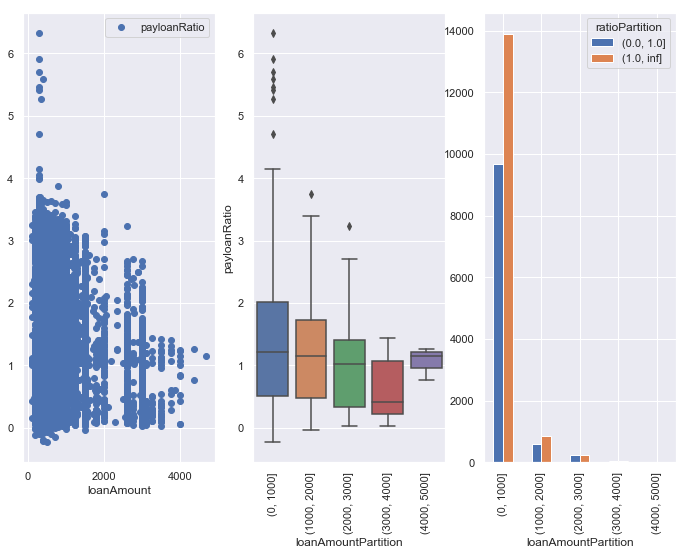

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

funded_loan.plot(x='loanAmount', y='payloanRatio', style='o', ax=ax1)
sns.boxplot(x=funded_loan['loanAmountPartition'], y=funded_loan['payloanRatio'], ax=ax2)
funded_loan.groupby(funded_loan['loanAmountPartition'])['ratioPartition'].value_counts().unstack().plot.bar(ax=ax3)
plt.setp(ax2.get_xticklabels(), rotation=90)

plt.show()

In [23]:
funded_loan['loanAmount'].corr(funded_loan['payloanRatio'], method='pearson')

-0.0762512528831908

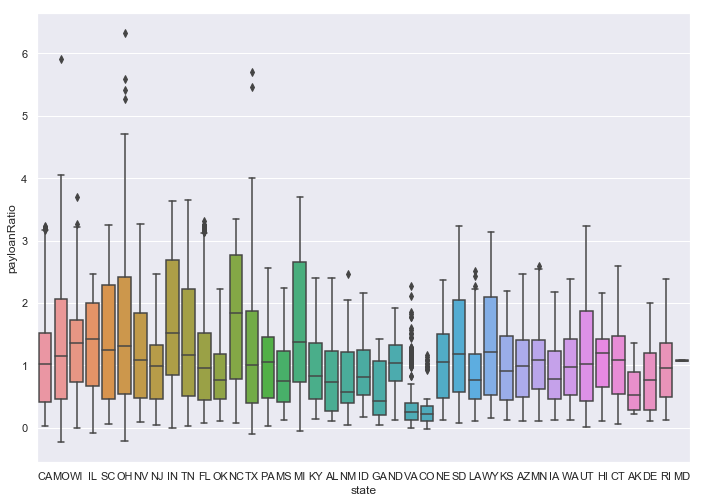

In [24]:
sns.boxplot(x=funded_loan.index.get_level_values('state'), y=funded_loan['payloanRatio'])
plt.show()

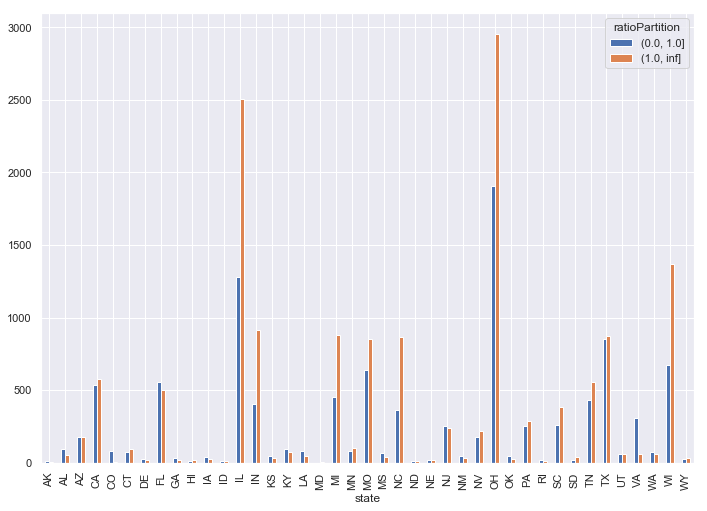

In [25]:
funded_loan.groupby(funded_loan.index.get_level_values('state'))['ratioPartition'].value_counts().unstack().plot.bar()
plt.show()

# Narrow Down Data for Model

In [26]:
funded_loan.reset_index(level=['state'], inplace=True)

In [27]:
input_columns_used_continuous = ['apr', 'loanAmount', 'clearfraudscore']
input_columns_used_categorical = ['state', 'payFrequency', 'nPaidOff', 'fpStatus', 'hasCF']
output_column = ['ratioPartition']
columns_used = input_columns_used_continuous + input_columns_used_categorical + output_column
data = funded_loan[columns_used]

In [28]:
# input_columns_used_continuous = ['apr']
# input_columns_used_categorical = ['state', 'payFrequency', 'nPaidOff', 'fpStatus', 'hasCF', 'clearfraudscorePartition', 'loanAmountPartition']
# output_column = ['ratioPartition']
# columns_used = input_columns_used_continuous + input_columns_used_categorical + output_column
# data = funded_loan[columns_used]

In [29]:
missing_data(data)

,Total,Percentage
clearfraudscore,5309,17.197927
ratioPartition,5298,17.162293
nPaidOff,21,0.068027
fpStatus,8,0.025915
hasCF,0,0.000000
payFrequency,0,0.000000
state,0,0.000000
loanAmount,0,0.000000
apr,0,0.000000


Drop all rows with missing values. 'hasCF' only has value 0 after dropping NaN, hence drop it too.

In [30]:
data.dropna(inplace=True)

In [31]:
missing_data(data)

,Total,Percentage
ratioPartition,0,0.0
hasCF,0,0.0
fpStatus,0,0.0
nPaidOff,0,0.0
payFrequency,0,0.0
state,0,0.0
clearfraudscore,0,0.0
loanAmount,0,0.0
apr,0,0.0


# Machine Learning Models

In [32]:
encoder = LabelEncoder()

data[input_columns_used_categorical + output_column] = \
data[input_columns_used_categorical + output_column].apply(encoder.fit_transform)

input_features = input_columns_used_continuous+input_columns_used_categorical
normalized_features =(data[input_features]-data[input_features].mean())/data[input_features].std()
data[input_features] = normalized_features
data.drop(columns=['hasCF'], inplace=True)

In [33]:
data.describe()

,apr,loanAmount,clearfraudscore,state,payFrequency,nPaidOff,fpStatus,ratioPartition
count,2.090000e+04,2.090000e+04,2.090000e+04,2.090000e+04,2.090000e+04,2.090000e+04,2.090000e+04,20900.000000
mean,-5.618662e-14,6.962480e-16,9.041146e-17,-4.090295e-18,4.647638e-16,5.062139e-16,6.602268e-16,0.572823
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.494680
min,-4.123537e+00,-1.124796e+00,-4.289044e+00,-2.002740e+00,-8.072530e-01,-3.221432e-01,-4.267675e+00,0.000000
25%,-6.526752e-01,-5.519292e-01,-7.192521e-01,-8.455241e-01,-8.072530e-01,-3.221432e-01,-1.713029e-01,0.000000
50%,5.043613e-01,-2.915351e-01,8.166265e-02,-7.404703e-02,-8.072530e-01,-3.221432e-01,-1.713029e-01,1.000000
75%,5.952649e-01,1.250955e-01,7.910443e-01,6.009954e-01,1.397391e+00,-3.221432e-01,-1.713029e-01,1.000000
max,1.256381e+00,8.430627e+00,2.125902e+00,1.758211e+00,1.397391e+00,2.471847e+01,8.021442e+00,1.000000


Check the correlations among the input variables and the output. The correlations among the indenpendent variables are small, hence we do not have to worry about the multi-collinearity problem here. However, the correlations between the output and the inputs are too low, suggesting that the model might not give a good prediction. Ideally, transformations need to be performed on the input variables in such a way that they are more linearly correlated to the output. To this end, kernal methods such as SVM can be employed to transform the input variables. 

Nevertheless, 3 different models are tested here, namely Random Forest, Logistic Regression and SVM.

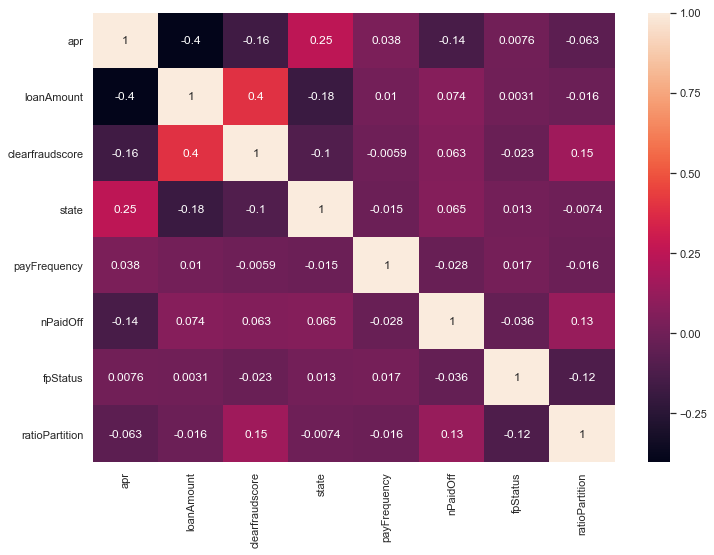

In [34]:
sns.heatmap(data.corr(), annot=True)
plt.show()

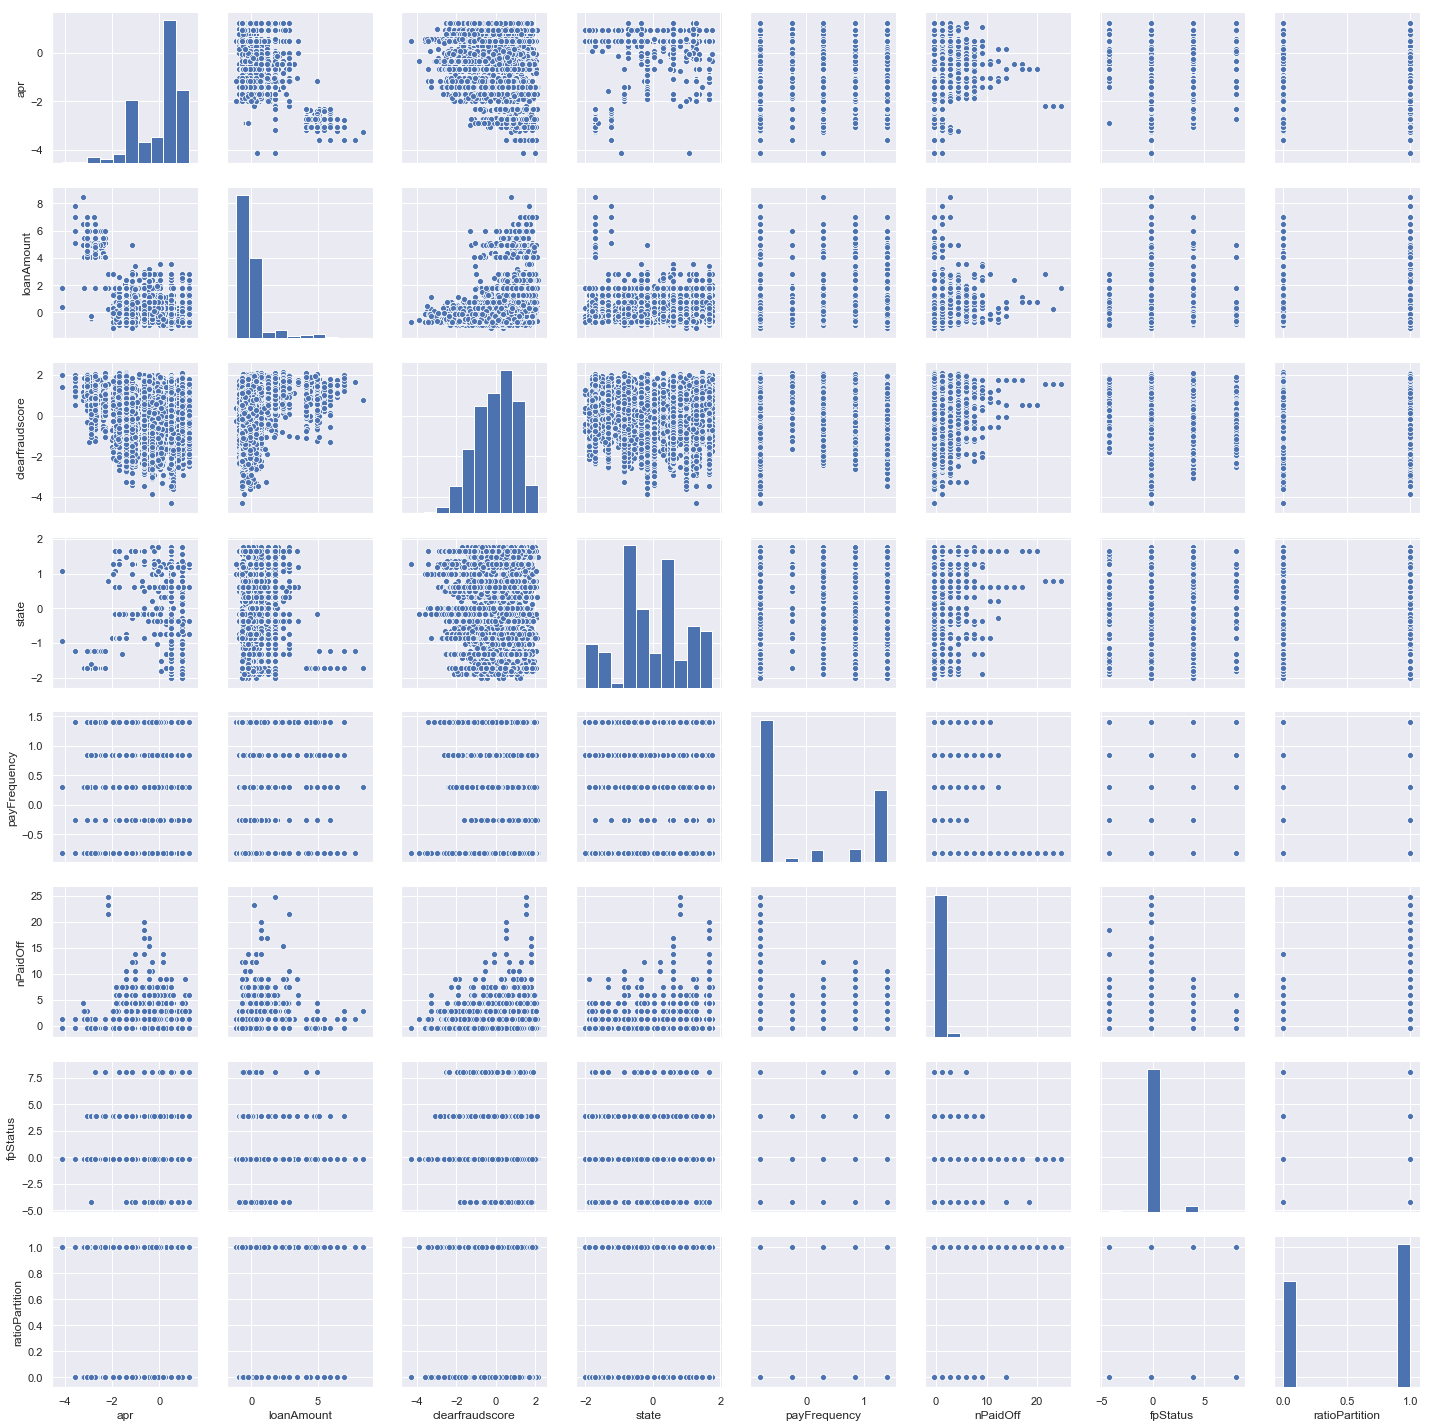

In [35]:
sns.pairplot(data)
plt.show()

## Random Forest Model

In [36]:
# data.drop(columns=['loanAmount'], inplace=True)

Train Test ratio is set at 9:1 to get more training data seeing that the data size is not huge.

In [37]:
X_train, X_test, y_train, y_test = \
train_test_split(data.iloc[:, 0:-1], data.iloc[:, -1], test_size=0.1, random_state=42)

rf = RandomForestClassifier(n_estimators=100)
parameters = {'criterion': ['gini', 'entropy'],
             'max_features': [None, 'sqrt', 'log2']}
clf = GridSearchCV(rf, parameters, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': [None, 'sqrt', 'log2'], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
prediction = clf.predict(X_test)

Confusion matrix, accuracy, precision, recall and F1 score will all be calculated for each of the models

In [39]:
confusion = pd.DataFrame(confusion_matrix(np.array(list(y_test)), prediction))
confusion.rename(columns={0: 'Predicted Loss', 1: 'Predicted Profit'}, 
                              index={0: 'Actual Loss', 1: 'Actual Profit'})

,Predicted Loss,Predicted Profit
Actual Loss,456,452
Actual Profit,389,793


In [40]:
accuracy = accuracy_score(np.array(list(y_test)), prediction) * 100
accuracy

59.760765550239235

In [41]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.54      0.50      0.52       908
           1       0.64      0.67      0.65      1182

   micro avg       0.60      0.60      0.60      2090
   macro avg       0.59      0.59      0.59      2090
weighted avg       0.59      0.60      0.60      2090



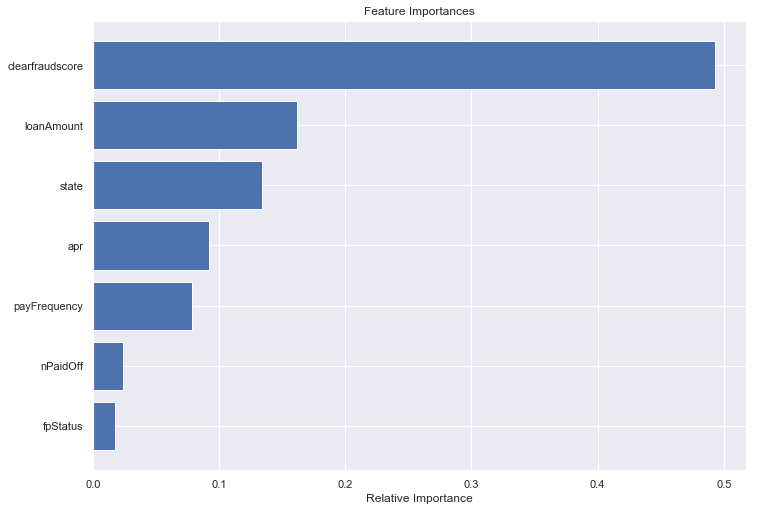

In [42]:
importances = clf.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [input_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Logistic Regression Model

In [43]:
log_reg_data = data.copy()
# log_reg_data.iloc[:, 0:-1] = np.exp(log_reg_data.iloc[:, 0:-1])

In [44]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = \
train_test_split(log_reg_data.iloc[:, 0:-1], log_reg_data.iloc[:, -1], test_size=0.1, random_state=42)

In [45]:
logistic_reg_model = LogisticRegression(solver='saga')

In [46]:
parameters_logistic_reg = {'penalty': ['l1', 'l2'], 'C': np.linspace(0.1, 1, 4)}
logistic_reg = GridSearchCV(logistic_reg_model, parameters_logistic_reg, cv=5)
logistic_reg.fit(X_train_lr, y_train_lr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([0.1, 0.4, 0.7, 1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [47]:
logistic_reg_predict = logistic_reg.predict(X_test_lr)
logistic_reg_predict

array([1, 0, 1, ..., 0, 0, 1])

In [48]:
accuracy_logistic_reg = accuracy_score(np.array(list(y_test_lr)), logistic_reg_predict) * 100
accuracy_logistic_reg

61.81818181818181

In [49]:
confusion_logistic_reg = pd.DataFrame(confusion_matrix(np.array(list(y_test)), logistic_reg_predict))
confusion_logistic_reg.rename(columns={0: 'Predicted Loss', 1: 'Predicted Profit'}, 
                              index={0: 'Actual Loss', 1: 'Actual Profit'})

,Predicted Loss,Predicted Profit
Actual Loss,342,566
Actual Profit,232,950


In [50]:
print(classification_report(y_test, logistic_reg_predict))

              precision    recall  f1-score   support

           0       0.60      0.38      0.46       908
           1       0.63      0.80      0.70      1182

   micro avg       0.62      0.62      0.62      2090
   macro avg       0.61      0.59      0.58      2090
weighted avg       0.61      0.62      0.60      2090



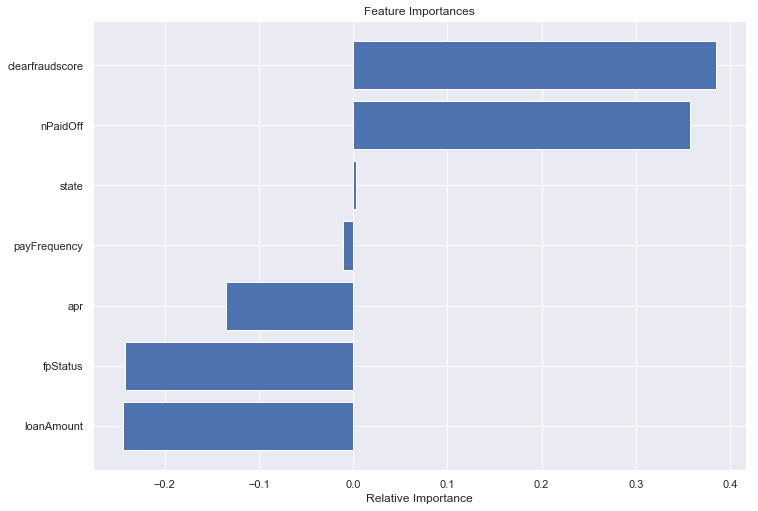

In [51]:
logistic_reg_importances = logistic_reg.best_estimator_.coef_[0]
logistic_reg_indices = np.argsort(logistic_reg_importances)

plt.title('Feature Importances')
plt.barh(range(len(logistic_reg_indices)), logistic_reg_importances[logistic_reg_indices], color='b', align='center')
plt.yticks(range(len(logistic_reg_indices)), [input_features[i] for i in logistic_reg_indices])
plt.xlabel('Relative Importance')
plt.show()

## Support Vector Machine

In [52]:
svm_data = data.copy()

In [53]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = \
train_test_split(svm_data.iloc[:, 0:-1], svm_data.iloc[:, -1], test_size=0.1, random_state=42)

In [54]:
svm_model = svm.SVC(gamma='scale')

In [55]:
parameters_svm = {'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
support_vector = GridSearchCV(svm_model, parameters_svm, cv=5)
support_vector.fit(X_train_svm, y_train_svm)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
svm_predict = support_vector.predict(X_test_svm)

In [57]:
accuracy_svm = accuracy_score(np.array(list(y_test_svm)), svm_predict) * 100
accuracy_svm

62.44019138755981

In [58]:
confusion_svm = pd.DataFrame(confusion_matrix(np.array(list(y_test)), svm_predict))
confusion_svm.rename(columns={0: 'Predicted Loss', 1: 'Predicted Profit'}, 
                              index={0: 'Actual Loss', 1: 'Actual Profit'})

,Predicted Loss,Predicted Profit
Actual Loss,373,535
Actual Profit,250,932


In [59]:
print(classification_report(y_test, svm_predict))

              precision    recall  f1-score   support

           0       0.60      0.41      0.49       908
           1       0.64      0.79      0.70      1182

   micro avg       0.62      0.62      0.62      2090
   macro avg       0.62      0.60      0.60      2090
weighted avg       0.62      0.62      0.61      2090



# Remarks

All rows with NaN are dropped because I am not sure what it means. In certain cases, it could just mean 0 from my interpretation, but to be on the safe side, they are all dropped for consistency. 

In terms of accuracy, SVM performs the best as expected, because the input variables have very low correlations with the output. However, a 62% accuracy is still quite low. The model can be improved in a few ways: get more data and train a deep learning model, include the other features that have been excluded in the models above, develop the domain knowledge to understand the data better and transform the data more appropriately. 